In [39]:
import numpy as np
import matplotlib.pylab as plt
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
np.random.seed(12211)  

In [40]:
num_train = 200000
num_test = 20000
Trainset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][6]#6
Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew', 'OBSuq'][7]
surveystring = surveystring = ['SDSS', 'VIPERS', 'DEEP2', 'PRIMUS']

n_epochs = 2000 #20
D = 5 
K = 3
learning_rate = 1e-5
decay_rate= 1e-3 
batch_size = 1024 
save_mod = 'saved_hubs/tf2models/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [41]:
def load_trained_models(save_mod):
    ## load rescaling routines for colors/magnitude
    preproc = Pipeline([('stdscaler', StandardScaler())])
    scalerfile = save_mod + '_scaling_X'
    preproc = pickle.load(open(scalerfile, 'rb'))
    
    ## load rescaling routine for redshift
    preproc_y = Pipeline([('stdscaler', MinMaxScaler())])
    scalerfile = save_mod + '_scaling_y'
    preproc_y = pickle.load(open(scalerfile, 'rb'))

    ## Mixed density network
    non_lin_act = tf.nn.relu #tf.nn.tanh
    y_true = tf.keras.Input(shape=(1,))
    inputs = tf.keras.Input(shape=(D,))
    layer_1 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(inputs)
    layer_1a = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1)
    layer_1b = tf.keras.layers.Dense(units=2048, activation=non_lin_act)(layer_1a)
    layer_1c = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1b)
    layer_2 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(layer_1c)
    layer_3 = tf.keras.layers.Dense(units=256, activation=non_lin_act)(layer_2)
    layer_4 = tf.keras.layers.Dense(units=128, activation=non_lin_act)(layer_3)
    layer_5 = tf.keras.layers.Dense(units=64, activation=non_lin_act)(layer_4)
    layer_6 = tf.keras.layers.Dense(units=32, activation=non_lin_act)(layer_5)
    mu = tf.keras.layers.Dense(units=K, activation=None, name="mu")(layer_6)
    var = tf.keras.backend.exp(tf.keras.layers.Dense(units=K, activation=tf.nn.softplus, name="sigma")(layer_6))
    pi = tf.keras.layers.Dense(units=K, activation=tf.nn.softmax, name="mixing")(layer_6)
    model_train = Model([inputs, y_true], [mu, var, pi], name='mdn')
    
    # load network weights
    model_train.load_weights(save_mod + '.h5')
    
    return preproc, preproc_y, model_train

In [42]:
def minmax_cutsOBSarr(X, y, l):
    mask_cond =  np.where( 
        (X[:, 0] < max_col[0]) & (X[:, 0] > min_col[0]) &
        (X[:, 1] < max_col[1]) & (X[:, 1] > min_col[1]) &
        (X[:, 2] < max_col[2]) & (X[:, 2] > min_col[2]) &
        (X[:, 3] < max_col[3]) & (X[:, 3] > min_col[3]) & 
        (X[:, 4] < max_mag) & (X[:, 4] > min_mag) &
        (y < max_z) & (y > min_z) )
    X_new = X[mask_cond]
    y_new = y[mask_cond]
    l_new = l[mask_cond]
    return X_new, y_new, l_new, mask_cond

In [43]:
def print_limits(X, y):
    print(10*'-')
    print('number of datapoints: ', str(y.shape[0]))
    print('z-minmax: ', y.min(), y.max())
    print('ColMag-min: ', np.min(X, axis=0))
    print('ColMag-max: ', np.max(X, axis=0))
    print(10*'-')

In [44]:
def loadTest(dirIn = '../../Data/fromGalaxev/photozs/datasets/data_feb_2021/'):
    
    test_data = np.load(dirIn + 'test_' + Testset + '.npy') 

    X_test = test_data[: , :-1]
    y_test = test_data[: , -1]

    print_limits(X_test, y_test)

    X_err = np.load(dirIn + 'test_' + Testset +'_err.npy') 
    test_labels = np.load(dirIn + 'test_' + Testset + '_label.npy') 

    return X_test, y_test, X_err, test_labels

In [45]:
## Loading color, redshift information from different surveys
X_test, y_test, X_err, label_test = loadTest(dirIn = 'Data/fromGalaxev/photozs/datasets/data_feb_2021/')

----------
number of datapoints:  4339
z-minmax:  7.926745e-06 7.01
ColMag-min:  [ -5.188479   -3.8901405  -2.1034117 -15.92296    12.114799 ]
ColMag-max:  [17.02884   7.925968  4.182415  2.264679 25.709858]
----------


In [46]:
## Removing galaxies outside the range of prediction scheme. 
min_col = [-0.09145837, -0.05327791, -0.02479261, -0.10519464] #-0.03 #-5
max_col = [ 3.825315,   2.8303378,  1.6937237,  1.5019817] #3.4 #5
min_mag = 12
max_mag = 23
min_z = 0.001 #np.min(y_train) 
max_z = 1.1 #np.max(y_train) 

X_test, y_test, label_test, mask_cond = minmax_cutsOBSarr(X_test, y_test, label_test)
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in test data: (2741, 5)
Size of output in test data: (2741,)


In [47]:
## Loading trained models and rescaling routines
preproc, preproc_y, model_train = load_trained_models(save_mod)

In [48]:
## Prediction 
X_test = preproc.transform(X_test)
y_pred = np.array(model_train(X_test))

In [49]:
## Best prediction (mean and std) of the Gaussian mixture is taken as the the one with highest weight
y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]
y_pred_std = np.sqrt(np.log(y_pred[1, :, :][:, y_pred_arg][:, 0]))

/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


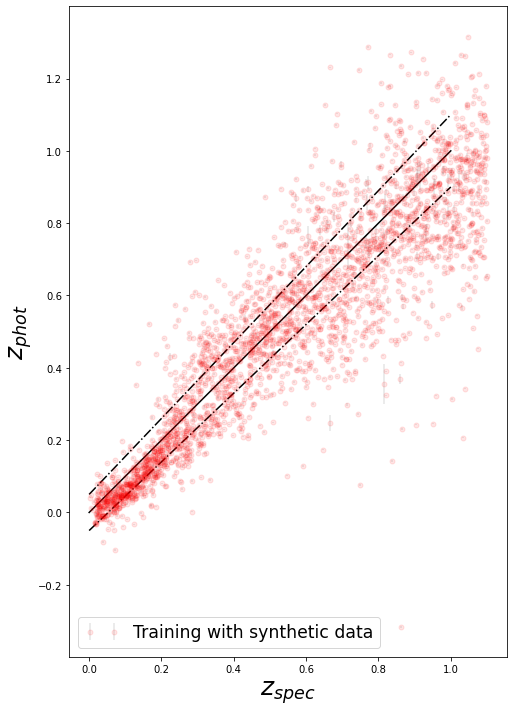

In [50]:
## Plotting mean and std-dev of predictions. The bias in prediction is clearly seen (esp at low-z)
y_pred_mean_best = y_pred_mean
y_pred_std_best = y_pred_std

plt.figure(figsize=(10, 10))

plt.errorbar(y_test, preproc_y.inverse_transform(y_pred_mean.reshape(-1, 1))[:, 0], 
             yerr= preproc_y.inverse_transform(y_pred_std.reshape(-1, 1) )[:, 0], 
             fmt='ro', ecolor='k', ms = 5, alpha = 0.1, label = 'Training with synthetic data')

C = 0.05
z_t = np.array([0, 1])
z_tp = z_t + C*(1+z_t)
z_tm = z_t - C*(1+z_t)
plt.plot(z_t, z_t, 'k')
plt.plot(z_t, z_tp, 'k-.')
plt.plot(z_t, z_tm, 'k-.')
plt.ylabel(r'$z_{phot}$', fontsize=25)
plt.xlabel(r'$z_{spec}$', fontsize=25)
plt.tight_layout()
plt.axes().set_aspect('equal')
leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

plt.show()

/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using

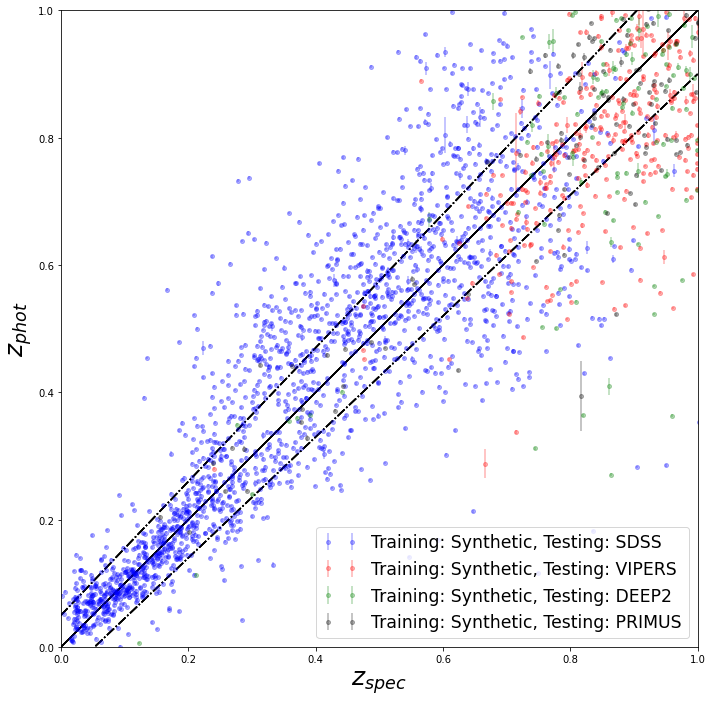

In [51]:
## Plotting survey-based predictions. With a manually set offset 
offset = 0.04


for label_ind in [0, 1, 2, 3]:
    plt.figure(22,figsize=(10, 10,)) 
    colorstring = ['b', 'r', 'g', 'k']
    surveyindx = np.where(label_test == label_ind)
    
    plt.errorbar(y_test[surveyindx], offset + preproc_y.inverse_transform(y_pred_mean_best.reshape(-1, 1))[surveyindx][:, 0],
                 yerr= preproc_y.inverse_transform(y_pred_std_best.reshape(-1, 1))[surveyindx][:, 0],
                 fmt = 'o', marker=None, ms = 4, alpha = 0.3, label = 'Training: Synthetic, Testing: '+surveystring[label_ind],
                 c = colorstring[label_ind])

    C = 0.05
    z_t = np.array([0, 1])
    z_tp = z_t + C*(1+z_t)
    z_tm = z_t - C*(1+z_t)
    plt.plot(z_t, z_t, 'k')
    plt.plot(z_t, z_tp, 'k-.')
    plt.plot(z_t, z_tm, 'k-.')

    plt.ylabel(r'$z_{phot}$', fontsize=25)
    plt.xlabel(r'$z_{spec}$', fontsize=25)
    plt.xlim(0.0, 1)
    plt.ylim(0.0, 1)
    plt.tight_layout()
    plt.axes().set_aspect('equal')
    leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

plt.show()